In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


In [ ]:
print("Started")
import numpy as np, pandas as pd
print("Pandas version - ", pd.__version__)
from pandas import MultiIndex, Int16Dtype

import os
import warnings
from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
NUM_WORKERS = 4

try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns
import matplotlib.pyplot as plt
import time
#import cupy, cudf
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Importing RFE and LinearRegression
try:
    import statsmodels.api as sm
except:
    !python -m pip install statsmodels
    import statsmodels.api as sm

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model,tree,svm
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split


try:
    import pickle
except:
    !pip install pickle5
    import pickle

import optuna

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

DEBUG = False
TRAIN_MODEL = True
INFER_TEST = False
ONE_FOLD_ONLY = True
COMPUTE_LSTM_IMPORTANCE = True

if DEBUG:
    train = train[:80*1000]

from sklearn.metrics import mean_absolute_error
print("All necessary libraries imported")

Started
Pandas version -  1.3.5
All necessary libraries imported


In [ ]:
# Not going to use testdf and sample df for thesis
traindf = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
testdf = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
sample_sub = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')


print(traindf.shape, " - Training dataset shape")
print(testdf.shape, " - Testing dataset shape")
print(sample_sub.shape, " - Sample Submission dataset shape")

(6036000, 8)  - Training dataset shape
(4024000, 7)  - Testing dataset shape
(4024000, 2)  - Sample Submission dataset shape


In [ ]:
# Adding features in the dataframe

def add_features(df):
    #https://www.kaggle.com/code/papernist/google-brain
    df = df.copy()
    
    df_group = df.groupby(['breath_id'])
    
    
    feature_list = ['u_in', 'time_step', 'cross']
    
    df['cross']= df['u_in'] * df['u_out']
    df['area_out']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    
    # add
    df['air_flow_rate'] = df['u_out'] - (df['u_in']/100.0)
    df['air_flow_area'] = df['air_flow_rate'] * df['time_step']
    print("Step-1...Completed")
    
    # cumsum cummean
    df['one'] = 1
    df['count'] = df_group['one'].cumsum()
    for feature in feature_list:
        df[f'{feature}_cumsum'] = df_group[feature].cumsum()
        df[f'{feature}_cummean'] = df[f'{feature}_cumsum'] / df['count']
        
    print("Step-2 cumsum cummean ...Completed")
    # lagging
    use_lags = 4
    for lag in range(1, use_lags+1):
        for feature in feature_list:
            # lag 
            df[f'{feature}_lag_{lag}'] = df_group[feature].shift(lag)
            # inverse lag
            df[f'{feature}_lag_inverse_{lag}'] = df_group[feature].shift(-lag)

            # dif lag
            df[f'{feature}_lag_diff_{lag}'] = df[feature] - df[f'{feature}_lag_{lag}']

            # dif inverse lag
            df[f'{feature}_lag_inverse_diff_{lag}'] = df[feature] - df[f'{feature}_lag_inverse_{lag}']

            df = df.drop(columns=[f'{feature}_lag_{lag}', f'{feature}_lag_inverse_{lag}'])
        
    df = df.fillna(0)
    print("Step-3 lagging ...Completed")
    
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    df = df.fillna(0)
    print("Step-4 categorical ...Completed")
    
    rolling_list = [15]
    for roll in rolling_list:
        for feature in feature_list:
            df[[f'{roll}_{feature}_sum',f'{roll}_{feature}_min',
                f'{roll}_{feature}_max',f'{roll}_{feature}_mean']] = (df_group[feature]\
                                                                  .rolling(window=roll,min_periods=1)\
                                                                  .agg({f'{roll}_{feature}_sum':'sum',
                                                                        f'{roll}_{feature}_min':'min',
                                                                        f'{roll}_{feature}_max':'max',
                                                                        f'{roll}_{feature}_mean':'mean'})\
                                                                   .reset_index(level=0,drop=True))
    
    print("Step-5 Sliding window...Completed")
    print()
    
    df = df.fillna(0)
    df = df.drop(['id', 'breath_id','one','count'], axis=1)
    
    return df.astype(np.float16)

In [ ]:
def cross_val(model):
    pred = cross_val_score(model, X_train, y_train, cv=10)
    return pred.mean()


def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square    

In [ ]:
%%time
data = add_features(traindf)
#test = add_features(testdf)

print("*"*70)
print(data.shape, " - Feature added training dataset shape")
#print(test.shape, " - Features added testing dataset shape")

Step-1...Completed
Step-2 cumsum cummean ...Completed
Step-3 lagging ...Completed
Step-4 categorical ...Completed
Step-5 Sliding window...Completed

**********************************************************************
(6036000, 66)  - Feature added training dataset shape
CPU times: user 2min 5s, sys: 32.6 s, total: 2min 38s
Wall time: 2min 38s


In [ ]:
binary_col = []
num_col = []

for columnname in data.columns:
  if len(set(data[columnname])) != 2:
    num_col.append(columnname)
  else:
    binary_col.append(columnname)

train_numcol = num_col.copy()
train_numcol.remove('pressure')

print(len(binary_col), "Number of Binary Categorical Columns")
print(len(num_col),"Number of Numerical Columns")
print(len(binary_col)+len(num_col), "Sum of Binary & Numerical Columns")

16 Number of Binary Categorical Columns
50 Number of Numerical Columns
66 Sum of Binary & Numerical Columns


In [ ]:
df_train, df_test = train_test_split(data, train_size = 0.7, test_size = 0.3, random_state = 100)
print("Split Done")

train = df_train.copy()
test = df_test.copy()
train_only = data.copy()

print("*"*70)
print("Splitting the data into X test & Y test")
print(train.shape, "Train shape")
print(test.shape, "Test shape")

Split Done
**********************************************************************
Splitting the data into X test & Y test
(4225200, 66) Train shape
(1810800, 66) Test shape


In [ ]:
train_only.columns

Index(['time_step', 'u_in', 'u_out', 'pressure', 'cross', 'area_out', 'area',
       'air_flow_rate', 'air_flow_area', 'u_in_cumsum', 'u_in_cummean',
       'time_step_cumsum', 'time_step_cummean', 'cross_cumsum',
       'cross_cummean', 'u_in_lag_diff_1', 'u_in_lag_inverse_diff_1',
       'time_step_lag_diff_1', 'time_step_lag_inverse_diff_1',
       'cross_lag_diff_1', 'cross_lag_inverse_diff_1', 'u_in_lag_diff_2',
       'u_in_lag_inverse_diff_2', 'time_step_lag_diff_2',
       'time_step_lag_inverse_diff_2', 'cross_lag_diff_2',
       'cross_lag_inverse_diff_2', 'u_in_lag_diff_3',
       'u_in_lag_inverse_diff_3', 'time_step_lag_diff_3',
       'time_step_lag_inverse_diff_3', 'cross_lag_diff_3',
       'cross_lag_inverse_diff_3', 'u_in_lag_diff_4',
       'u_in_lag_inverse_diff_4', 'time_step_lag_diff_4',
       'time_step_lag_inverse_diff_4', 'cross_lag_diff_4',
       'cross_lag_inverse_diff_4', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20',
       'C_50', 'R__C_20__10', 'R__C_20__20', '

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

targets = train_only[['pressure']].to_numpy().reshape(-1, 80)
train_only.drop(['pressure'], axis=1, inplace=True)

COLS = list(train_only.columns)
print('Number of feature columns =', len(COLS) )

MMS = MinMaxScaler()
train = MMS.fit_transform(train_only)
#test = MMS.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
#test = test.reshape(-1, 80, train.shape[-1])

Number of feature columns = 65


In [ ]:
train.shape

(75450, 80, 65)

--------------- > Fold 1 < ---------------
Epoch 1/300
67/67 [==============================] - 136s 2s/step - loss: 4.8737 - val_loss: 3.9610

Epoch 00001: val_loss improved from inf to 3.96098, saving model to folds0.hdf5
Epoch 2/300
67/67 [==============================] - 118s 2s/step - loss: 3.5115 - val_loss: 3.9234

Epoch 00002: val_loss improved from 3.96098 to 3.92344, saving model to folds0.hdf5
Epoch 3/300
67/67 [==============================] - 118s 2s/step - loss: 3.1838 - val_loss: 3.0924

Epoch 00003: val_loss improved from 3.92344 to 3.09241, saving model to folds0.hdf5
Epoch 4/300
67/67 [==============================] - 118s 2s/step - loss: 2.9776 - val_loss: 2.8115

Epoch 00004: val_loss improved from 3.09241 to 2.81145, saving model to folds0.hdf5
Epoch 5/300
67/67 [==============================] - 118s 2s/step - loss: 2.5060 - val_loss: 2.0744

Epoch 00005: val_loss improved from 2.81145 to 2.07442, saving model to folds0.hdf5
Epoch 6/300
67/67 [=================

  0%|          | 0/65 [00:00<?, ?it/s]

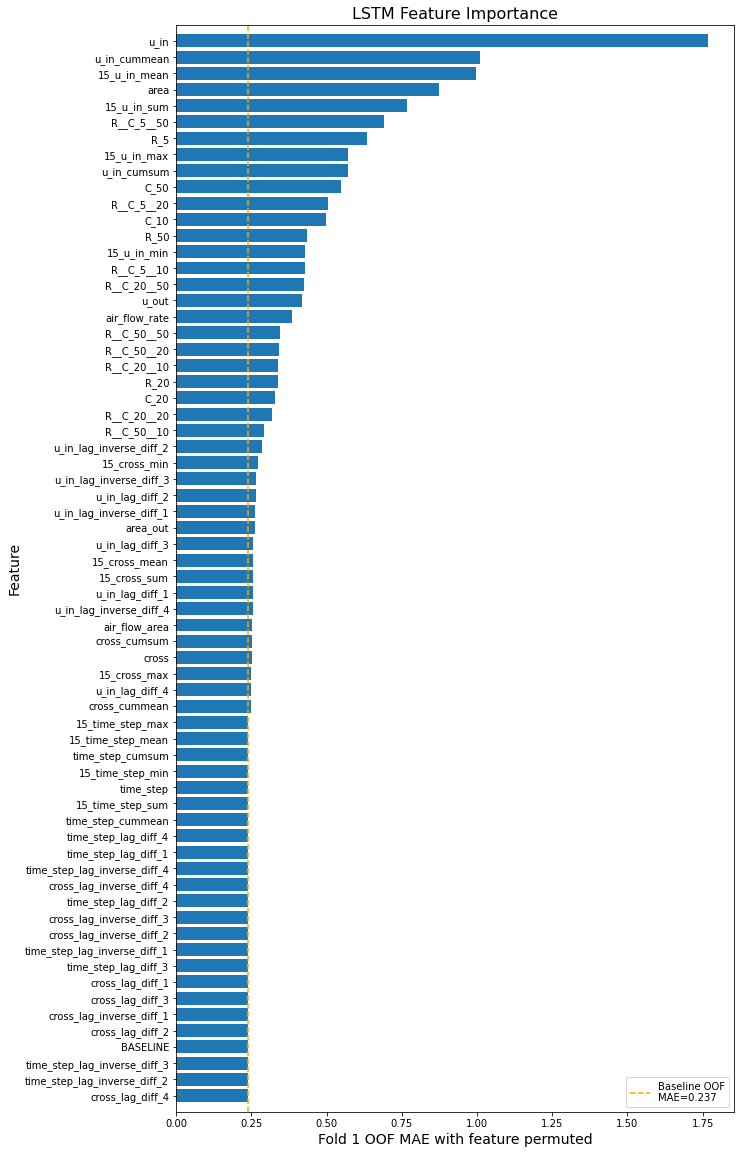

In [ ]:
EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.Input(shape=train.shape[-2:]),
                keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
                keras.layers.Dense(128, activation='selu'),
                keras.layers.Dense(1),
            ])
            model.compile(optimizer="adam", loss="mae")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
            
        else:
            model = keras.models.load_model('../input/finetune-of-tensorflow-bidirectional-lstm/'+checkpoint_filepath)

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(test,verbose=0).squeeze().reshape(-1, 1).squeeze())
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model.predict(X_valid, verbose=0).squeeze() 
            baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
            results.append({'feature':'BASELINE','mae':baseline_mae})           

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid[:,:,k].copy()
                np.random.shuffle(X_valid[:,:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_valid, verbose=0).squeeze() 
                mae = np.mean(np.abs( oof_preds-y_valid ))
                results.append({'feature':COLS[k],'mae':mae})
                X_valid[:,:,k] = save_col
         
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break